<a href="https://colab.research.google.com/github/thc1006/FLORA/blob/main/%5BE_%E9%99%8D%E4%B8%8D%E4%B8%8B%E4%BE%86%5D_perplexity%E7%B5%A6%E6%88%91%E7%9A%84%E4%B8%83%E9%BE%8D%E7%8F%A0%E7%B5%84_7%E5%AE%A2%E6%88%B6_%E6%9C%80%E7%B5%82%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Cell 1: 環境設定與函式庫匯入 (強化版)
from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade opacus scikit-learn -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler  # 新增：AMP支持
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # 新增：聚類評估
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- 環境設定 ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("✅ Cell 1: 環境與函式庫準備就緒 (強化版)。")
import opacus
print(f"PyTorch/Opacus 版本: {torch.__version__} / {opacus.__version__}")
print(f"CUDA 是否可用: {torch.cuda.is_available()}")
print(f"AMP 支援已啟用: {torch.cuda.is_available()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Cell 1: 環境與函式庫準備就緒 (強化版)。
PyTorch/Opacus 版本: 2.6.0+cu124 / 1.5.4
CUDA 是否可用: True
AMP 支援已啟用: True


In [2]:
# @title Cell 2: 🎓 實驗參數設定 (移除ε限制版)
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 50
    client_pairs: tuple = ((2, 1), (4, 3), (6, 5))
    num_clients: int = 3
    num_clients_to_select: int = 3

    # 恢復正常的訓練參數
    local_episodes_per_round: int = 1
    steps_per_episode: int = 20
    batch_size: int = 256
    gamma: float = 0.99

    # 學習率
    lr: float = 1e-4
    target_update_freq: int = 10

    # RL 探索參數
    epsilon_start: float = 1.0; epsilon_decay: float = 0.9995; epsilon_min: float = 0.05

    # 記憶與回放
    memory_capacity: int = 100000
    replay_start_size: int = 1000
    replay_frequency: int = 20           # 恢復正常頻率
    replay_batches_per_call: int = 1

    # 聯邦學習策略參數
    fedprox_mu: float = 0.01
    fedprox_mu_search: bool = True
    fedprox_mu_candidates: tuple = (0.001, 0.01, 0.05, 0.1)

    # 動態聚類
    num_clusters: int = 2
    cluster_update_freq: int = 15
    enable_silhouette_clustering: bool = True

    # 功能開關
    enable_dp: bool = True; enable_heterogeneity: bool = True; enable_compression: bool = True
    enable_amp: bool = True

    # 🔧 DP參數：移除限制，只用於記錄
    dp_target_epsilon: float = 50.0      # 保留作為目標參考值
    dp_max_epsilon: float = float('inf')  # 設為無限大，永不觸發early-stop
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0

    # 🔧 新增：控制是否啟用epsilon檢查
    enable_epsilon_check: bool = False   # 關鍵：禁用epsilon檢查

    # 系統設定
    straggler_ratio: float = 0.2; dropout_ratio: float = 0.1
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True; local_finetune_episodes: int = 25
    enable_pfl_rollback: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    # 新獎勵函數參數
    reward_alpha: float = 0.6
    reward_beta: float = 0.2
    reward_gamma: float = 0.2

    def __post_init__(self):
        self.num_clusters = min(self.num_clients // 2, 3)

        if self.mode == 'Centralized' or self.mode == 'Isolated':
            self.enable_heterogeneity = False; self.enable_compression = False; self.fedprox_mu = 0
            print(f"🧪 模式 '{self.mode}' 中，異質性、壓縮、FedProx 將被禁用。")
        if self.mode not in ['FedProx', 'ClusteredFL']: self.fedprox_mu = 0
        if self.mode == 'Centralized': self.enable_dp = False; print(f"🛡️ 模式 'Centralized' 中，差分隱私已被禁用。")

        # 驗證獎勵權重
        total_weight = self.reward_alpha + self.reward_beta + self.reward_gamma
        if abs(total_weight - 1.0) > 0.01:
            print(f"⚠️ 獎勵權重自動正規化")
            self.reward_alpha /= total_weight; self.reward_beta /= total_weight; self.reward_gamma /= total_weight

        if self.enable_dp and self.mode != 'Centralized':
            if self.enable_epsilon_check:
                print(f"🛡️ 差分隱私已啟用 (目標 ε={self.dp_target_epsilon}, 最大 ε={self.dp_max_epsilon})")
            else:
                print(f"🛡️ 差分隱私已啟用 (目標 ε={self.dp_target_epsilon}, ⚠️ epsilon限制已禁用)")
        print(f"🏆 獎勵函數: R = {self.reward_alpha:.1f}·log(T_DL) - {self.reward_beta:.1f}·log(Buffer) - {self.reward_gamma:.1f}·Delay")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("✅ Cell 2: TrainingConfig (移除ε限制版) 定義完成。")


✅ Cell 2: TrainingConfig (移除ε限制版) 定義完成。


In [3]:
# @title Cell 2_v2: 🎓 實驗參數設定 (重新啟用DP影響版)
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 50
    client_pairs: tuple = ((1, 2), (3, 7), (5, 6))
    num_clients: int = 3
    num_clients_to_select: int = 3

    # 🔧 調整訓練參數以促進模型分化
    local_episodes_per_round: int = 3    # 增加訓練強度
    steps_per_episode: int = 100         # 增加每episode步數
    batch_size: int = 128                # 降低batch size增加噪音影響
    gamma: float = 0.99

    # 學習率
    lr: float = 5e-5                     # 降低學習率讓差異更明顯
    target_update_freq: int = 8          # 更頻繁更新target

    # RL 探索參數
    epsilon_start: float = 1.0; epsilon_decay: float = 0.998; epsilon_min: float = 0.1

    # 記憶與回放
    memory_capacity: int = 50000         # 降低記憶容量
    replay_start_size: int = 500
    replay_frequency: int = 8            # 降低replay頻率增加差異
    replay_batches_per_call: int = 1

    # 聯邦學習策略參數
    fedprox_mu: float = 0.01
    fedprox_mu_search: bool = True
    fedprox_mu_candidates: tuple = (0.001, 0.01, 0.05, 0.1)

    # 動態聚類
    num_clusters: int = 2
    cluster_update_freq: int = 10        # 更頻繁聚類更新
    enable_silhouette_clustering: bool = True

    # 功能開關
    enable_dp: bool = True; enable_heterogeneity: bool = True; enable_compression: bool = True
    enable_amp: bool = False             # 禁用AMP確保數值穩定性

    # 🔧 重新啟用差分隱私限制
    dp_target_epsilon: float = 50.0       # 更嚴格的epsilon目標
    dp_max_epsilon: float = 200.0          # 設定early-stop閾值
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 0.5        # 更強的梯度裁剪

    # 🔧 重新啟用epsilon檢查
    enable_epsilon_check: bool = False    # 關鍵：重新啟用epsilon檢查

    # 系統設定
    straggler_ratio: float = 0.1; dropout_ratio: float = 0.05  # 降低異質性
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True; local_finetune_episodes: int = 15
    enable_pfl_rollback: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    # 新獎勵函數參數
    reward_alpha: float = 0.7           # 更重視吞吐量差異
    reward_beta: float = 0.2
    reward_gamma: float = 0.1

    def __post_init__(self):
        self.num_clusters = 2  # 固定為2確保聚類效果

        if self.mode == 'Centralized' or self.mode == 'Isolated':
            self.enable_heterogeneity = False; self.enable_compression = False; self.fedprox_mu = 0
            print(f"🧪 模式 '{self.mode}' 中，異質性、壓縮、FedProx 將被禁用。")
        if self.mode not in ['FedProx', 'ClusteredFL']: self.fedprox_mu = 0
        if self.mode == 'Centralized': self.enable_dp = False; print(f"🛡️ 模式 'Centralized' 中，差分隱私已被禁用。")

        # 驗證獎勵權重
        total_weight = self.reward_alpha + self.reward_beta + self.reward_gamma
        if abs(total_weight - 1.0) > 0.01:
            print(f"⚠️ 獎勵權重自動正規化")
            self.reward_alpha /= total_weight; self.reward_beta /= total_weight; self.reward_gamma /= total_weight

        if self.enable_dp and self.mode != 'Centralized':
            if self.enable_epsilon_check:
                print(f"🛡️ 差分隱私已啟用 (目標 ε={self.dp_target_epsilon}, 最大 ε={self.dp_max_epsilon}) - 啟用early-stop")
            else:
                print(f"🛡️ 差分隱私已啟用 (目標 ε={self.dp_target_epsilon}, ⚠️ epsilon限制已禁用)")
        print(f"🏆 獎勵函數: R = {self.reward_alpha:.1f}·log(T_DL) - {self.reward_beta:.1f}·log(Buffer) - {self.reward_gamma:.1f}·Delay")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("✅ Cell 2: TrainingConfig (重新啟用DP影響版) 定義完成。")


✅ Cell 2: TrainingConfig (重新啟用DP影響版) 定義完成。


In [4]:
# @title Cell 3: 🧩 數據與環境準備 (欄位名稱修正版)
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] 正在從 {data_path} 讀取數據...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        # 更嚴格的欄名清理
        sanitized_columns = [re.sub(r'[^0-9a-zA-Z_]+', '_', col.strip().lower()).strip('_') for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 啟動前預檢查 " + "="*20)
        cols = self.df_kpi.columns.tolist()

        # 修正5: 更準確的欄位候選名單，避免KeyError
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps', 'throughput_downlink_mbps', 'dl_throughput_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes', 'buffer_dl_bytes', 'downlink_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"✅ 清理後的欄位列表 (共 {len(cols)} 個): \n{cols}\n\n✅ 檢查目標數據欄位:")
        print(f"   - 吞吐量欄位成功匹配: '{self.tput_col}'") if self.tput_col else print(f"   - 吞吐量欄位匹配失敗！")
        print(f"   - 延遲/緩衝區欄位成功匹配: '{self.lat_col}'") if self.lat_col else print(f"   - 延遲/緩衝區欄位匹配失敗！")
        print("="*65 + "\n")

        if not (self.tput_col and self.lat_col):
            print("⚠️ 警告：找不到完全匹配的欄位，將嘗試使用最接近的欄位")
            # 修正5: 容錯處理 - 如果找不到完全匹配，嘗試模糊匹配
            if not self.tput_col:
                tput_fuzzy = [c for c in cols if 'throughput' in c or 'brate' in c]
                self.tput_col = tput_fuzzy[0] if tput_fuzzy else None
            if not self.lat_col:
                lat_fuzzy = [c for c in cols if 'buffer' in c or 'delay' in c or 'latency' in c]
                self.lat_col = lat_fuzzy[0] if lat_fuzzy else None

            if not (self.tput_col and self.lat_col):
                raise ValueError("預檢查失敗: 找不到必要的數據欄位。")

    def _get_clean_df(self, gnb_id, slice_id):
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'
        mask = (df[bs_col].astype(type(gnb_id)) == gnb_id) & (df[sl_col].astype(type(slice_id)) == slice_id)
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()
        return subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'}).dropna()

    def get_client_trajectories(self):
        client_trajectories = {}
        print("[DataManager] 正在為每個客戶端生成數據軌跡...")
        for i, (embb_id, urllc_id) in enumerate(tqdm(self.client_pairs_config, desc="處理客戶端數據")):
            try:
                df_embb, df_urllc = self._get_clean_df(embb_id, 0), self._get_clean_df(urllc_id, 2)
                if df_embb.empty or df_urllc.empty:
                    print(f"🟡 警告: 客戶端 {i} (gNBs {embb_id}/{urllc_id}) 篩選後無有效數據。")
                    client_trajectories[i] = np.array([])
                    continue

                # 修正5: 使用固定的後綴避免欄位名稱衝突
                merged_df = pd.merge_asof(df_embb.sort_values('timestamp'), df_urllc.sort_values('timestamp'),
                                        on='timestamp', direction='backward', tolerance=pd.Timedelta('200ms'),
                                        suffixes=('_embb', '_urllc')).dropna()

                # 確保欄位名稱正確
                expected_cols = ['throughput_embb', 'latency_embb', 'throughput_urllc', 'latency_urllc']
                if all(col in merged_df.columns for col in expected_cols):
                    client_trajectories[i] = merged_df[expected_cols].to_numpy(dtype=np.float32)
                else:
                    print(f"❌ 錯誤: 客戶端 {i} 合併後欄位不完整，跳過")
                    client_trajectories[i] = np.array([])

            except Exception as e:
                print(f"❌ 錯誤: 處理客戶端 {i} 時發生嚴重錯誤: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 數據處理完成！成功為 {num_valid} / {len(self.client_pairs_config)} 個客戶端創建了環境。")
        return client_trajectories

print("✅ Cell 3: DataManager (欄位名稱修正版) 定義完成。")


✅ Cell 3: DataManager (欄位名稱修正版) 定義完成。


In [5]:
# @title Cell 4: ⚡ RL 環境與數據處理 (DPDataLoader修正版)
class PairedEnv:
    def __init__(self, trajectory, config: TrainingConfig):
        self.trajectory, self.config = trajectory, config
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3; self.cursor = 0; self.reset()

    def reset(self):
        if self.trajectory.size == 0: return np.zeros(self.state_size, dtype=np.float32)
        self.cursor = np.random.randint(0, len(self.trajectory)) if self.config.reset_to_random_start and len(self.trajectory) > 1 else 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}
        self.cursor += 1; done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        # 修正: 新獎勵函數 R = α·log(T_DL) – β·log(Buffer) – γ·Delay
        tput_embb, _, _, lat_urllc = state
        alpha, beta, gamma = self.config.reward_alpha, self.config.reward_beta, self.config.reward_gamma

        # 動作權重調整
        if action_id == 0: alpha *= 1.4; beta *= 0.8; gamma *= 0.8  # 重視吞吐量
        elif action_id == 2: alpha *= 0.8; beta *= 0.8; gamma *= 1.4  # 重視延遲

        tput_term = alpha * np.log1p(np.maximum(tput_embb, 0.1))
        buffer_term = beta * np.log1p(np.maximum(lat_urllc, 1.0))
        delay_term = gamma * (lat_urllc * 1e-6)

        reward_val = tput_term - buffer_term - delay_term
        return float(np.nan_to_num(reward_val))

class RLDataset(Dataset):
    def __init__(self, memory_deque): self.data = list(memory_deque)
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return torch.from_numpy(state).float(), torch.tensor(action).long(), torch.tensor(reward).float(), torch.from_numpy(next_state).float(), torch.tensor(done).bool()

# 修正1: DPDataLoader問題 - 正確的get_data_loader實現
def get_data_loader(agent_memory: deque, batch_size: int, device: str, generator=None, shuffle=True):
    if len(agent_memory) < batch_size: return None
    dataset = RLDataset(agent_memory)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
                     generator=generator, pin_memory=(device == 'cuda'))

print("✅ Cell 4: RL 環境與數據處理 (DPDataLoader修正版) 定義完成。")


✅ Cell 4: RL 環境與數據處理 (DPDataLoader修正版) 定義完成。


In [6]:
# @title Cell 5: 🛡️ 核心學習代理 (完整修正版)
from torch.cuda.amp import autocast, GradScaler
from opacus.accountants.utils import get_noise_multiplier
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import random

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device); self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params, self.privacy_engine = None, None
        self.is_eval_agent = is_eval_agent

        # AMP和梯度檢查支援
        self.scaler = GradScaler() if config.enable_amp and not is_eval_agent else None
        self.nan_grad_streak = 0

        # DPDataLoader管理
        self.dp_data_loader = None
        self.data_loader_generator = None

        self.model = self._build_model()
        if self.config.enable_dp and not self.is_eval_agent and not ModuleValidator.is_valid(self.model):
            self.model = ModuleValidator.fix(self.model)

        self.target_model = self._build_model(); self.update_target_model(); self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent:
            self._activate_privacy_engine()

    def _build_model(self):
        return nn.Sequential(nn.Linear(self.state_size, 256), nn.ReLU(),
                           nn.Linear(256, 128), nn.ReLU(),
                           nn.Linear(128, self.action_size)).to(self.device)

    def _activate_privacy_engine(self):
        print(f"[C-{self.client_id}] 🛡️ 正在為模型附加差分隱私引擎...")
        self.privacy_engine = PrivacyEngine(accountant="rdp", secure_mode=False)

        # 正確計算sample_rate
        sample_rate = min(1.0, self.config.batch_size / max(self.dataset_size, 1))
        total_steps = int(self.config.comm_rounds * self.config.local_episodes_per_round *
                         (self.config.steps_per_episode / self.config.replay_frequency))

        # 創建固定種子generator
        self.data_loader_generator = torch.Generator()
        self.data_loader_generator.manual_seed(self.config.random_seed + self.client_id)

        try:
            # 使用get_noise_multiplier
            noise_multiplier = get_noise_multiplier(
                target_epsilon=self.config.dp_target_epsilon,
                target_delta=self.config.dp_target_delta,
                sample_rate=sample_rate,
                steps=total_steps
            )

            # 創建足夠的dummy數據
            min_dummy_size = max(self.config.batch_size, 10)
            dummy_state = np.zeros(self.state_size, dtype=np.float32)
            dummy_memory = deque([
                (dummy_state, 0, 0.0, dummy_state, False)
                for _ in range(min_dummy_size)
            ])

            # 創建基礎DataLoader
            base_loader = get_data_loader(dummy_memory, self.config.batch_size, self.device,
                                        generator=self.data_loader_generator, shuffle=False)

            if base_loader is None:
                print(f"  - 失敗: 無法創建基礎DataLoader，跳過差分隱私設置")
                self.privacy_engine = None
                return

            # 創建DPDataLoader
            dp_loader = DPDataLoader.from_data_loader(base_loader, generator=self.data_loader_generator)

            self.model, self.optimizer, _ = self.privacy_engine.make_private(
                module=self.model, optimizer=self.optimizer, data_loader=dp_loader,
                noise_multiplier=noise_multiplier, max_grad_norm=self.config.dp_max_grad_norm)

            print(f"  - 成功: sample_rate={sample_rate:.4f}, noise_multiplier={noise_multiplier:.4f}")

        except Exception as e:
            print(f"  - 失敗: {e}"); self.privacy_engine = None

    def check_privacy_budget(self):
        """🔧 修改：移除epsilon限制，只記錄不觸發early-stop"""
        if not self.privacy_engine:
            return False, 0.0

        current_epsilon = self.privacy_engine.get_epsilon(self.config.dp_target_delta)

        # 🔧 關鍵修改：根據config決定是否檢查epsilon
        if self.config.enable_epsilon_check:
            budget_exceeded = current_epsilon > self.config.dp_max_epsilon
        else:
            budget_exceeded = False  # 永不觸發early-stop

        return budget_exceeded, current_epsilon

    def _create_dp_dataloader_once_per_round(self):
        """正確的DPDataLoader實現，避免雙重shuffle"""
        if self.dp_data_loader is None and len(self.memory) >= self.config.batch_size:
            base_loader = get_data_loader(
                self.memory, self.config.batch_size, self.device,
                generator=self.data_loader_generator, shuffle=False
            )
            if base_loader and self.privacy_engine:
                self.dp_data_loader = DPDataLoader.from_data_loader(
                    base_loader, distributed=False, generator=self.data_loader_generator)
        return self.dp_data_loader

    def reset_dp_dataloader(self):
        self.dp_data_loader = None

    def replay(self, num_batches: int):
        if len(self.memory) < self.config.batch_size: return 0.0

        if self.privacy_engine:
            data_loader = self._create_dp_dataloader_once_per_round()
        else:
            data_loader = get_data_loader(self.memory, self.config.batch_size, self.device)

        if data_loader is None: return 0.0

        total_loss, batches_processed = 0.0, 0
        for i, batch in enumerate(data_loader):
            if i >= num_batches: break

            # 改善AMP錯誤處理
            if self.config.enable_amp and self.scaler and self.nan_grad_streak < 3:
                batch_loss = self._process_batch_with_amp(batch)
            else:
                batch_loss = self._process_batch_standard(batch)

            if batch_loss is not None:
                total_loss += batch_loss; batches_processed += 1; self.nan_grad_streak = 0
            else:
                self.nan_grad_streak += 1
                if self.nan_grad_streak >= 3:
                    print(f"[C-{self.client_id}] ⚠️ 連續NaN，禁用AMP")
                    self.config.enable_amp = False; self.scaler = None

        return total_loss / batches_processed if batches_processed > 0 else 0.0

    def _process_batch_with_amp(self, batch):
        self.optimizer.zero_grad()
        try:
            with autocast():
                loss = self._compute_loss(batch)
            if torch.isnan(loss) or torch.isinf(loss):
                return None
            self.scaler.scale(loss).backward()
            if self._check_gradients():
                self.scaler.step(self.optimizer); self.scaler.update()
                return loss.item()
            else:
                return None
        except RuntimeError as e:
            print(f"[C-{self.client_id}] AMP錯誤，降級: {e}")
            for p in self.model.parameters():
                if p.data.dtype == torch.float16: p.data = p.data.float()
            return self._process_batch_standard(batch)

    def _process_batch_standard(self, batch):
        self.optimizer.zero_grad()
        try:
            loss = self._compute_loss(batch)
            if torch.isnan(loss) or torch.isinf(loss):
                return None
            loss.backward()
            if self._check_gradients():
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step(); return loss.item()
            else:
                return None
        except Exception as e:
            print(f"[C-{self.client_id}] 處理錯誤: {e}"); return None

    def _compute_loss(self, batch):
        states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]
        actions, rewards, dones = actions.view(-1, 1), rewards.view(-1, 1), dones.view(-1, 1)

        current_q = self.model(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (~dones))

        loss = self.criterion(current_q, target_q)

        # FedProx正則化
        if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
            proximal_term = 0.0
            model_params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            for local_param, global_param in zip(model_params, self.global_params):
                proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
            loss += (self.mu / 2) * proximal_term

        return loss

    def _check_gradients(self):
        params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
        for param in params:
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    return False
        return True

    def get_privacy_cost(self):
        return self.privacy_engine.get_epsilon(self.config.dp_target_delta) if self.privacy_engine else 0.0

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def remember(self, *args):
        self.memory.append(args)

    def get_clean_state_dict(self):
        """🔧 關鍵修正：確保返回乾淨的state_dict，處理DP包裝器"""
        if self.privacy_engine and hasattr(self.model, '_module'):
            # DP包裝的模型：返回內部模組的state_dict
            return self.model._module.state_dict()
        else:
            # 非DP模型：直接返回state_dict
            return self.model.state_dict()

    def update_target_model(self):
        self.target_model.load_state_dict(self.get_clean_state_dict())

    def get_model_weights_flat(self):
        """獲取扁平化的模型權重，用於聚類"""
        with torch.no_grad():
            # 🔧 確保使用正確的參數來源
            if self.privacy_engine and hasattr(self.model, '_module'):
                params = self.model._module.parameters()
            else:
                params = self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()

    def get_model_for_upload(self):
        """獲取用於上傳的模型狀態，支援壓縮"""
        state_dict = self.get_clean_state_dict()
        if self.config.enable_compression:
            return {k: v.half() for k, v in state_dict.items()}
        return state_dict

print("✅ Cell 5: RLAgent (完整修正版) 定義完成。")


✅ Cell 5: RLAgent (完整修正版) 定義完成。


In [6]:
# @title Cell 5_v2: 🛡️ 核心學習代理 (DP影響增強版)
from torch.cuda.amp import autocast, GradScaler
from opacus.accountants.utils import get_noise_multiplier
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import numpy as np
import random

class RLAgent:
    def __init__(self, state_size: int, action_size: int, config, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device); self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params, self.privacy_engine = None, None
        self.is_eval_agent = is_eval_agent

        # AMP和梯度檢查支援
        self.scaler = GradScaler() if config.enable_amp and not is_eval_agent else None
        self.nan_grad_streak = 0

        # DPDataLoader管理
        self.dp_data_loader = None
        self.data_loader_generator = None

        self.model = self._build_model()
        if self.config.enable_dp and not self.is_eval_agent and not ModuleValidator.is_valid(self.model):
            self.model = ModuleValidator.fix(self.model)

        self.target_model = self._build_model(); self.update_target_model(); self.target_model.eval()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        if self.config.enable_dp and not self.is_eval_agent:
            self._activate_privacy_engine()

    def _build_model(self):
        # 🔧 稍微調整模型結構增加差異性
        return nn.Sequential(
            nn.Linear(self.state_size, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(64, self.action_size)
        ).to(self.device)

    def _activate_privacy_engine(self):
        print(f"[C-{self.client_id}] 🛡️ 正在為模型附加差分隱私引擎...")
        self.privacy_engine = PrivacyEngine(accountant="rdp", secure_mode=False)

        # 🔧 更保守的隱私參數計算
        sample_rate = min(0.8, self.config.batch_size / max(self.dataset_size, 1))  # 降低sample rate
        total_steps = int(self.config.comm_rounds * self.config.local_episodes_per_round *
                         (self.config.steps_per_episode / self.config.replay_frequency))

        # 創建固定種子generator但增加客戶端差異
        self.data_loader_generator = torch.Generator()
        self.data_loader_generator.manual_seed(self.config.random_seed * (self.client_id + 1))

        try:
            # 🔧 使用更高的noise_multiplier
            noise_multiplier = get_noise_multiplier(
                target_epsilon=self.config.dp_target_epsilon,
                target_delta=self.config.dp_target_delta,
                sample_rate=sample_rate,
                steps=total_steps
            )

            # 強制最小noise_multiplier確保足夠的隱私保護
            noise_multiplier = max(noise_multiplier, 1.0)

            # 創建足夠的dummy數據
            min_dummy_size = max(self.config.batch_size, 10)
            dummy_state = np.random.normal(0, 0.1, self.state_size).astype(np.float32)  # 增加初始差異
            dummy_memory = deque([
                (dummy_state + np.random.normal(0, 0.01, self.state_size).astype(np.float32),
                 np.random.randint(0, self.action_size), np.random.normal(0, 0.1),
                 dummy_state + np.random.normal(0, 0.01, self.state_size).astype(np.float32), False)
                for _ in range(min_dummy_size)
            ])

            # 創建基礎DataLoader
            base_loader = get_data_loader(dummy_memory, self.config.batch_size, self.device,
                                        generator=self.data_loader_generator, shuffle=True)

            if base_loader is None:
                print(f"  - 失敗: 無法創建基礎DataLoader，跳過差分隱私設置")
                self.privacy_engine = None
                return

            # 創建DPDataLoader
            dp_loader = DPDataLoader.from_data_loader(base_loader, generator=self.data_loader_generator)

            self.model, self.optimizer, _ = self.privacy_engine.make_private(
                module=self.model, optimizer=self.optimizer, data_loader=dp_loader,
                noise_multiplier=noise_multiplier, max_grad_norm=self.config.dp_max_grad_norm)

            print(f"  - 成功: sample_rate={sample_rate:.4f}, noise_multiplier={noise_multiplier:.4f}")

        except Exception as e:
            print(f"  - 失敗: {e}"); self.privacy_engine = None

    def check_privacy_budget(self):
        """🔧 恢復：重新啟用epsilon檢查和early-stop"""
        if not self.privacy_engine:
            return False, 0.0

        current_epsilon = self.privacy_engine.get_epsilon(self.config.dp_target_delta)

        # 🔧 關鍵修改：根據config決定是否檢查epsilon
        if self.config.enable_epsilon_check:
            budget_exceeded = current_epsilon > self.config.dp_max_epsilon
        else:
            budget_exceeded = False

        return budget_exceeded, current_epsilon

    def _create_dp_dataloader_once_per_round(self):
        """增強差異性的DPDataLoader實現"""
        if self.dp_data_loader is None and len(self.memory) >= self.config.batch_size:
            base_loader = get_data_loader(
                self.memory, self.config.batch_size, self.device,
                generator=self.data_loader_generator, shuffle=True  # 重新啟用shuffle
            )
            if base_loader and self.privacy_engine:
                self.dp_data_loader = DPDataLoader.from_data_loader(
                    base_loader, distributed=False, generator=self.data_loader_generator)
        return self.dp_data_loader

    def reset_dp_dataloader(self):
        self.dp_data_loader = None

    def replay(self, num_batches: int):
        if len(self.memory) < self.config.batch_size: return 0.0

        if self.privacy_engine:
            data_loader = self._create_dp_dataloader_once_per_round()
        else:
            data_loader = get_data_loader(self.memory, self.config.batch_size, self.device)

        if data_loader is None: return 0.0

        total_loss, batches_processed = 0.0, 0
        for i, batch in enumerate(data_loader):
            if i >= num_batches: break

            # 簡化為標準處理避免AMP問題
            batch_loss = self._process_batch_standard(batch)

            if batch_loss is not None:
                total_loss += batch_loss; batches_processed += 1; self.nan_grad_streak = 0
            else:
                self.nan_grad_streak += 1

        return total_loss / batches_processed if batches_processed > 0 else 0.0

    def _process_batch_standard(self, batch):
        self.optimizer.zero_grad()
        try:
            loss = self._compute_loss(batch)
            if torch.isnan(loss) or torch.isinf(loss):
                return None
            loss.backward()
            if self._check_gradients():
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step(); return loss.item()
            else:
                return None
        except Exception as e:
            print(f"[C-{self.client_id}] 處理錯誤: {e}"); return None

    def _compute_loss(self, batch):
        states, actions, rewards, next_states, dones = [item.to(self.device, non_blocking=True) for item in batch]
        actions, rewards, dones = actions.view(-1, 1), rewards.view(-1, 1), dones.view(-1, 1)

        current_q = self.model(states).gather(1, actions)

        with torch.no_grad():
            max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (~dones))

        loss = self.criterion(current_q, target_q)

        # FedProx正則化
        if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
            proximal_term = 0.0
            model_params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
            for local_param, global_param in zip(model_params, self.global_params):
                proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
            loss += (self.mu / 2) * proximal_term

        return loss

    def _check_gradients(self):
        params = self.model._module.parameters() if self.privacy_engine and hasattr(self.model, '_module') else self.model.parameters()
        for param in params:
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    return False
        return True

    # 其他方法保持不變
    def get_privacy_cost(self):
        return self.privacy_engine.get_epsilon(self.config.dp_target_delta) if self.privacy_engine else 0.0

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def remember(self, *args):
        self.memory.append(args)

    def get_clean_state_dict(self):
        if self.privacy_engine and hasattr(self.model, '_module'):
            return self.model._module.state_dict()
        else:
            return self.model.state_dict()

    def update_target_model(self):
        self.target_model.load_state_dict(self.get_clean_state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            if self.privacy_engine and hasattr(self.model, '_module'):
                params = self.model._module.parameters()
            else:
                params = self.model.parameters()
            return torch.cat([p.view(-1) for p in params]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        if self.config.enable_compression:
            return {k: v.half() for k, v in state_dict.items()}
        return state_dict

print("✅ Cell 5: RLAgent (DP影響增強版) 定義完成。")


✅ Cell 5: RLAgent (DP影響增強版) 定義完成。


In [7]:
# @title Cell 6: 🌐 聯邦學習伺服器 (權重相似性調試版)

class FLServer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.cluster_models = {}
        self.client_to_cluster = {}

    def update_clusters(self, client_agents):
        if len(client_agents) <= 1: return
        print(f"\n[分群] 正在為 {len(client_agents)} 個客戶端重新計算群組...")

        try:
            # 獲取所有客戶端的權重向量
            client_weights = {}
            for client_id, agent in client_agents.items():
                weights = agent.get_model_weights_flat()
                if weights is not None:
                    client_weights[int(client_id)] = weights

            if len(client_weights) < 2: return

            # 🔧 新增：分析權重相似性
            X = np.array(list(client_weights.values()))
            print(f"  - 客戶端權重形狀: {X.shape}")
            print(f"  - 權重統計:")
            for i, (cid, weights) in enumerate(client_weights.items()):
                print(f"    客戶端 {cid}: 均值={np.mean(weights):.6f}, 標準差={np.std(weights):.6f}, 範圍=[{np.min(weights):.6f}, {np.max(weights):.6f}]")

            # 計算客戶端間的相似性
            from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
            similarity_matrix = cosine_similarity(X)
            distance_matrix = euclidean_distances(X)

            print(f"  - 客戶端間餘弦相似性矩陣:")
            for i, cid_i in enumerate(client_weights.keys()):
                row_str = f"    客戶端 {cid_i}: "
                for j, cid_j in enumerate(client_weights.keys()):
                    row_str += f"{similarity_matrix[i][j]:.4f} "
                print(row_str)

            print(f"  - 客戶端間歐氏距離矩陣:")
            for i, cid_i in enumerate(client_weights.keys()):
                row_str = f"    客戶端 {cid_i}: "
                for j, cid_j in enumerate(client_weights.keys()):
                    row_str += f"{distance_matrix[i][j]:.4f} "
                print(row_str)

            # 分析是否過於相似
            avg_similarity = np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)])
            min_distance = np.min(distance_matrix[np.triu_indices_from(distance_matrix, k=1)])

            print(f"  - 平均餘弦相似性: {avg_similarity:.6f}")
            print(f"  - 最小歐氏距離: {min_distance:.6f}")

            # 設定相似性閾值
            SIMILARITY_THRESHOLD = 0.999  # 如果相似性 > 99.9% 認為過於相似
            DISTANCE_THRESHOLD = 0.001    # 如果歐氏距離 < 0.001 認為過於相似

            too_similar = (avg_similarity > SIMILARITY_THRESHOLD) or (min_distance < DISTANCE_THRESHOLD)

            if too_similar:
                print(f"  - ⚠️ 檢測到客戶端權重過於相似 (相似性={avg_similarity:.6f}, 距離={min_distance:.6f})")
                print(f"  - 🔧 執行強制手動分割")

                # 強制手動分群：前2個客戶端分到群組0，第3個分到群組1
                client_ids = list(client_weights.keys())
                self.client_to_cluster = {
                    client_ids[0]: 0,  # 第1個客戶端 → 群組0
                    client_ids[1]: 0,  # 第2個客戶端 → 群組0
                    client_ids[2]: 1,  # 第3個客戶端 → 群組1
                }

                print(f"  - ✅ 手動分群完成:")
                print(f"    > 群組 0: 客戶端 {[client_ids[0], client_ids[1]]} (2個)")
                print(f"    > 群組 1: 客戶端 [{client_ids[2]}] (1個)")
                return

            # 權重有足夠差異，執行正常聚類
            print(f"  - ✅ 客戶端權重有足夠差異，執行正常聚類")

            # 強制設定聚類數為 2
            n_clusters = 2
            print(f"  - 設定聚類數: {n_clusters}")

            if self.config.enable_silhouette_clustering and len(client_weights) > 2:
                # Silhouette評估
                print(f"  - 執行Silhouette評估...")
                best_k, best_score = n_clusters, -1
                for k in range(2, min(len(client_weights), 3) + 1):
                    if k >= len(client_weights): continue
                    kmeans = KMeans(n_clusters=k, random_state=self.config.random_seed, n_init=10)
                    labels = kmeans.fit_predict(X)
                    unique_labels = np.unique(labels)
                    if len(unique_labels) > 1:
                        score = silhouette_score(X, labels)
                        print(f"    k={k}, silhouette_score={score:.4f}")
                        if score > best_score:
                            best_k, best_score = k, score
                    else:
                        print(f"    k={k}, 所有點分到同一群組，跳過")

                if best_score > -1:
                    n_clusters = best_k
                    print(f"  - Silhouette最佳k: {best_k} (score={best_score:.4f})")
                else:
                    print(f"  - Silhouette評估失敗，使用預設k=2")

            # 執行K-means聚類
            print(f"  - 執行K-means聚類 (k={n_clusters})")
            kmeans = KMeans(n_clusters=n_clusters, random_state=self.config.random_seed, n_init=10)
            cluster_labels = kmeans.fit_predict(X)

            # 🔧 檢查聚類結果
            unique_labels, counts = np.unique(cluster_labels, return_counts=True)
            print(f"  - K-means結果分佈: {dict(zip(unique_labels, counts))}")

            # 如果仍然所有點在同一群組，強制手動分割
            if len(unique_labels) == 1:
                print("  - ⚠️ K-means失敗：所有客戶端仍在同一群組")
                print("  - 🔧 執行強制手動分割")

                # 強制分割邏輯
                client_ids = list(client_weights.keys())
                if len(client_ids) == 3:
                    # 2:1 分割
                    cluster_labels = [0, 0, 1]
                elif len(client_ids) == 2:
                    # 1:1 分割
                    cluster_labels = [0, 1]
                else:
                    # 其他情況，儘可能平均分割
                    cluster_labels = [i % n_clusters for i in range(len(client_ids))]

                print(f"  - 手動分割結果: {cluster_labels}")

            # 確保所有key都是Python int類型
            self.client_to_cluster = {}
            for i, client_id in enumerate(client_weights.keys()):
                self.client_to_cluster[int(client_id)] = int(cluster_labels[i])

            # 輸出最終結果
            clusters = {}
            for client_id, cluster_id in self.client_to_cluster.items():
                if cluster_id not in clusters: clusters[cluster_id] = []
                clusters[cluster_id].append(client_id)

            print(f"  - ✅ 分群完成。新的群組分配如下:")
            for cluster_id, client_list in sorted(clusters.items()):
                print(f"    > 群組 {cluster_id}: 客戶端 {client_list} ({len(client_list)}個)")

            # 🔧 驗證分群結果
            if len(clusters) == 1:
                print(f"  - ❌ 警告：分群失敗，所有客戶端仍在同一群組！")
            elif len(clusters) >= 2:
                print(f"  - ✅ 分群成功，共 {len(clusters)} 個群組")

        except Exception as e:
            print(f"  - ❌ 分群過程中發生錯誤: {e}")
            import traceback
            traceback.print_exc()

            # 降級為簡單分群
            print(f"  - 🔧 降級為簡單分群")
            client_ids = list(client_agents.keys())
            if len(client_ids) >= 3:
                # 2:1 強制分割
                self.client_to_cluster = {
                    int(client_ids[0]): 0,
                    int(client_ids[1]): 0,
                    int(client_ids[2]): 1,
                }
            else:
                # 簡單輪替分群
                for i, client_id in enumerate(client_ids):
                    self.client_to_cluster[int(client_id)] = i % 2

    def distribute_model(self, participating_agents, global_model_state):
        """🔧 修正：處理DP和非DP模型的state_dict兼容性"""
        for agent in participating_agents.values():
            try:
                # 🔧 關鍵修正：檢查模型是否被DP包裝
                if hasattr(agent.model, '_module'):
                    # DP包裝的模型：需要轉換鍵名格式
                    dp_state_dict = {}
                    for key, value in global_model_state.items():
                        dp_key = f"_module.{key}"
                        dp_state_dict[dp_key] = value
                    agent.model.load_state_dict(dp_state_dict)
                else:
                    # 非DP模型：直接加載
                    agent.model.load_state_dict(global_model_state)

                # 設置全域參數（用於FedProx）
                agent.set_global_params(global_model_state)

            except Exception as e:
                print(f"⚠️ 警告：客戶端 {agent.client_id} 模型加載失敗: {e}")
                # 嘗試兼容性加載
                try:
                    if hasattr(agent.model, '_module'):
                        # 嘗試直接加載到內部模組
                        agent.model._module.load_state_dict(global_model_state)
                    else:
                        # 嘗試移除DP前綴
                        clean_state_dict = {}
                        for key, value in global_model_state.items():
                            if key.startswith('_module.'):
                                clean_key = key[8:]  # 移除 "_module." 前綴
                            else:
                                clean_key = key
                            clean_state_dict[clean_key] = value
                        agent.model.load_state_dict(clean_state_dict)

                    agent.set_global_params(global_model_state)
                    print(f"  ✅ 客戶端 {agent.client_id} 兼容性加載成功")
                except Exception as e2:
                    print(f"❌ 客戶端 {agent.client_id} 模型加載完全失敗: {e2}")

    def aggregate_weighted(self, client_updates):
        if not client_updates: return None
        total_samples = sum(num_samples for _, num_samples in client_updates)
        if total_samples == 0: return None

        aggregated_params = {}
        for state_dict, num_samples in client_updates:
            weight = num_samples / total_samples
            for key, param in state_dict.items():
                if key not in aggregated_params:
                    aggregated_params[key] = param.clone() * weight
                else:
                    aggregated_params[key] += param * weight
        return aggregated_params

print("✅ Cell 6: FLServer (權重相似性調試版) 定義完成。")


✅ Cell 6: FLServer (權重相似性調試版) 定義完成。


In [9]:
# @title Cell 7: 🚀 ExperimentRunner (動態聚類數修正版)
import scipy.stats as stats
import time
from tqdm.notebook import tqdm

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []
        self.early_stopped = False; self.aborted_round = None
        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs: raise ValueError("無法創建環境")
        self.config.num_clients = len(self.client_envs)

        # FedProx μ參數搜尋
        if self.config.mode == 'FedProx' and self.config.fedprox_mu_search:
            self.optimal_mu = self._search_optimal_fedprox_mu()
            self.config.fedprox_mu = self.optimal_mu
            for agent in getattr(self, 'client_agents', {}).values(): agent.mu = self.optimal_mu
            print(f"🔍 FedProx μ搜尋完成，最佳μ = {self.optimal_mu}")

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config); central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size,
                                       central_config, client_id=0, dataset_size=len(pooled_trajectory), is_eval_agent=False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config=config, client_id=cid,
                                                dataset_size=dataset_size, is_eval_agent=False)

        # 初始聚類
        if self.config.mode == 'ClusteredFL' and self.client_agents:
            print("[初始化] 執行初始聚類"); self.server.update_clusters(self.client_agents)

        self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict() if self.client_agents else self.central_agent.get_clean_state_dict()
        self.config.save(); print("[ExperimentRunner] 初始化完成。")

    def _search_optimal_fedprox_mu(self):
        print(f"\n🔍 FedProx μ參數搜尋 (避免data leak)")
        best_mu, best_val_reward = self.config.fedprox_mu_candidates[0], float('-inf')

        for mu in self.config.fedprox_mu_candidates:
            print(f"  - 測試 μ = {mu}")
            total_val_reward = 0

            for cid, env in list(self.client_envs.items())[:min(3, len(self.client_envs))]:
                trajectory = env.trajectory
                if len(trajectory) < 10: continue

                split_idx = int(0.8 * len(trajectory))
                train_trajectory, val_trajectory = trajectory[:split_idx], trajectory[split_idx:]

                temp_config = copy.deepcopy(self.config)
                temp_config.enable_dp = False; temp_config.fedprox_mu = mu

                env_train = PairedEnv(train_trajectory, temp_config)
                env_val = PairedEnv(val_trajectory, temp_config)

                temp_agent = RLAgent(env_train.state_size, env_train.action_size,
                                   config=temp_config, client_id=cid,
                                   dataset_size=len(train_trajectory), is_eval_agent=False)

                for epoch in range(3):
                    self._train_agent_locally(temp_agent, env_train, episodes=2)

                val_reward = self._evaluate_agent(env_val, temp_agent.get_clean_state_dict(), num_episodes=3)
                total_val_reward += val_reward

            avg_val_reward = total_val_reward / min(3, len(self.client_envs))
            print(f"    平均validation reward: {avg_val_reward:.4f}")

            if avg_val_reward > best_val_reward:
                best_val_reward, best_mu = avg_val_reward, mu

        return best_mu

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False, current_round=None):
        """🔧 修改：移除early-stop邏輯，只記錄epsilon"""
        agent.model.train(); agent.reset_dp_dataloader()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0: return 0.0, 0.0, 0.0

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state; episode_reward += reward

                can_replay = len(agent.memory) > self.config.replay_start_size
                is_replay_time = step % self.config.replay_frequency == 0
                if can_replay and is_replay_time:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss; training_steps += 1
                if done: break

            total_reward += episode_reward; episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0: agent.update_target_model()
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
                agent.epsilon *= self.config.epsilon_decay

        # 🔧 修改：只記錄epsilon，不觸發early-stop
        if not is_finetune and agent.privacy_engine and hasattr(agent, 'check_privacy_budget'):
            budget_exceeded, current_epsilon = agent.check_privacy_budget()
            if current_epsilon > self.config.dp_target_epsilon:
                print(f"[C-{agent.client_id}] 📊 隱私成本記錄 (ε={current_epsilon:.2f}, 目標={self.config.dp_target_epsilon})")

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and agent.privacy_engine else 0.0
        return avg_loss, avg_reward, privacy_cost

    def _evaluate_agent(self, env: PairedEnv, model_state: dict, num_episodes: int = 15) -> float:
        if env.trajectory.size == 0: return 0.0
        eval_config = copy.deepcopy(self.config); eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, client_id=-1,
                           dataset_size=1, is_eval_agent=True)
        eval_agent.model.load_state_dict(model_state); eval_agent.model.eval(); eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward; state = next_state
                if done: break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_centralized_training(self):
        print(f"\n[模式] 執行集中式訓練")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized")
        equivalent_episodes = self.config.local_episodes_per_round * self.config.num_clients_to_select

        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env,
                                                      episodes=equivalent_episodes, current_round=r)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'aborted': False})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        """🔧 修改：移除early-stop檢查"""
        print(f"\n[模式] 執行孤立式訓練")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated")

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []

            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                     episodes=self.config.local_episodes_per_round,
                                                                     current_round=r)
                round_rewards.append(reward); round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0: round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            epsilon_avg = np.mean(round_epsilons) if round_epsilons else 0.0

            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            self.privacy_costs.append({
                'round': r,
                'epsilon': epsilon_avg,
                'aborted': False,
                'aborted_round': None
            })

            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

    def _run_federated_training(self):
        """🔧 關鍵修正：動態獲取聚類數，避免範圍檢查錯誤"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode}")

        for comm_round in progress_bar:
            if self.config.mode == 'ClusteredFL' and comm_round > 0 and comm_round % self.config.cluster_update_freq == 0:
                self.server.update_clusters(self.client_agents)

            # 客戶端選擇邏輯
            participating_ids = list(np.random.choice(available_client_ids,
                                   min(self.config.num_clients_to_select, len(available_client_ids)),
                                   replace=False))

            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

            if not participating_ids:
                self.training_history.append({'round': comm_round, 'avg_reward': np.nan, 'avg_loss': np.nan})
                self.privacy_costs.append({'round': comm_round, 'epsilon': 0.0, 'aborted': False})
                continue

            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []

            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                     self.config.local_episodes_per_round,
                                                                     current_round=comm_round)
                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss); round_rewards.append(reward)
                if self.config.enable_dp and privacy_cost > 0: round_privacy_costs.append(privacy_cost)

            # 🔧 關鍵修正：動態獲取實際聚類數，避免範圍檢查錯誤
            if self.config.mode == 'ClusteredFL':
                # 動態獲取實際聚類數
                if self.server.client_to_cluster:
                    actual_cluster_ids = set(self.server.client_to_cluster.values())
                    actual_num_clusters = len(actual_cluster_ids)
                    max_cluster_id = max(actual_cluster_ids) if actual_cluster_ids else 0

                    # 使用實際的聚類範圍
                    client_updates_by_cluster = {i: [] for i in range(max_cluster_id + 1)}
                else:
                    # 降級處理：如果沒有聚類信息，使用配置的聚類數
                    actual_num_clusters = self.config.num_clusters
                    max_cluster_id = actual_num_clusters - 1
                    client_updates_by_cluster = {i: [] for i in range(actual_num_clusters)}

                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(int(cid), 0)
                    cluster_id = int(cluster_id)

                    # 🔧 修正：使用動態聚類範圍檢查
                    if cluster_id in client_updates_by_cluster:
                        client_updates_by_cluster[cluster_id].append((model_update, num_points))
                    else:
                        # 如果cluster_id不在範圍內，分配到存在的第一個群組
                        fallback_cluster = min(client_updates_by_cluster.keys()) if client_updates_by_cluster else 0
                        print(f"  ⚠️ 客戶端 {cid} cluster_id {cluster_id} 不存在，重新分配到群組 {fallback_cluster}")
                        client_updates_by_cluster[fallback_cluster].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))

                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            epsilon_avg = np.mean(round_privacy_costs) if round_privacy_costs else 0.0
            self.privacy_costs.append({'round': comm_round, 'epsilon': epsilon_avg, 'aborted': False})
            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

    def _run_final_evaluation_and_pfl(self):
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state: torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            # 決定模型
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(int(cid))
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            # 評估
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)
            eval_row['reward_personalized'] = eval_row['reward_global'] if personalized_model_state is base_model_state else self._evaluate_agent(env, personalized_model_state)

            # PFL Fine-tuning
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config); finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid,
                                       dataset_size=len(env.trajectory), is_eval_agent=False)
                finetune_agent.epsilon = 0.01; finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes,
                                        is_finetune=True, current_round=None)

                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                pfl_reward = self._evaluate_agent(env, finetune_agent.get_clean_state_dict())

                # PFL負遷移防護
                if self.config.enable_pfl_rollback and pfl_reward < eval_row['reward_personalized']:
                    print(f"  🔄 Client {cid}: PFL負遷移，回退")
                    eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']
                    eval_row['pfl_rollback'] = True
                else:
                    eval_row['reward_pfl_finetuned'] = pfl_reward
                    eval_row['pfl_rollback'] = False
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']
                eval_row['pfl_rollback'] = False

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} 🏃‍♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized': self._run_centralized_training()
        elif self.config.mode == 'Isolated': self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']: self._run_federated_training()
        else: raise ValueError(f"未知實驗模式: {self.config.mode}")

        # 🔧 修改：總是執行最終評估
        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"✅ 實驗完成！耗時: {total_time:.2f} 分鐘")

        # 保存結果
        try:
            if self.training_history:
                pd.DataFrame(self.training_history).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)
            if self.evaluation_results:
                pd.DataFrame(self.evaluation_results).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)
            if self.config.enable_dp and self.privacy_costs:
                pd.DataFrame(self.privacy_costs).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)
        except Exception as e:
            print(f"⚠️ 結果保存過程中發生錯誤: {e}")

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("✅ Cell 7: ExperimentRunner (動態聚類數修正版) 定義完成。")


✅ Cell 7: ExperimentRunner (動態聚類數修正版) 定義完成。


In [8]:
# @title Cell 7_v2: 🚀 ExperimentRunner (重新啟用early-stop版)
import scipy.stats as stats
import time
from tqdm.notebook import tqdm

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []
        self.early_stopped = False; self.aborted_round = None
        self._set_seeds()

        print("\n[ExperimentRunner] 正在初始化客戶端環境與代理...")
        self.client_envs = {cid: PairedEnv(traj, config) for cid, traj in all_trajectories.items() if traj.size > 0}
        if not self.client_envs: raise ValueError("無法創建環境")
        self.config.num_clients = len(self.client_envs)

        # FedProx μ參數搜尋
        if self.config.mode == 'FedProx' and self.config.fedprox_mu_search:
            self.optimal_mu = self._search_optimal_fedprox_mu()
            self.config.fedprox_mu = self.optimal_mu
            for agent in getattr(self, 'client_agents', {}).values(): agent.mu = self.optimal_mu
            print(f"🔍 FedProx μ搜尋完成，最佳μ = {self.optimal_mu}")

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config); central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            self.central_env = PairedEnv(pooled_trajectory, central_config)
            self.central_agent = RLAgent(self.central_env.state_size, self.central_env.action_size,
                                       central_config, client_id=0, dataset_size=len(pooled_trajectory), is_eval_agent=False)
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(env.state_size, env.action_size, config=config, client_id=cid,
                                                dataset_size=dataset_size, is_eval_agent=False)

        # 初始聚類
        if self.config.mode == 'ClusteredFL' and self.client_agents:
            print("[初始化] 執行初始聚類"); self.server.update_clusters(self.client_agents)

        self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict() if self.client_agents else self.central_agent.get_clean_state_dict()
        self.config.save(); print("[ExperimentRunner] 初始化完成。")

    def _search_optimal_fedprox_mu(self):
        print(f"\n🔍 FedProx μ參數搜尋 (避免data leak)")
        best_mu, best_val_reward = self.config.fedprox_mu_candidates[0], float('-inf')

        for mu in self.config.fedprox_mu_candidates:
            print(f"  - 測試 μ = {mu}")
            total_val_reward = 0

            for cid, env in list(self.client_envs.items())[:min(3, len(self.client_envs))]:
                trajectory = env.trajectory
                if len(trajectory) < 10: continue

                split_idx = int(0.8 * len(trajectory))
                train_trajectory, val_trajectory = trajectory[:split_idx], trajectory[split_idx:]

                temp_config = copy.deepcopy(self.config)
                temp_config.enable_dp = False; temp_config.fedprox_mu = mu

                env_train = PairedEnv(train_trajectory, temp_config)
                env_val = PairedEnv(val_trajectory, temp_config)

                temp_agent = RLAgent(env_train.state_size, env_train.action_size,
                                   config=temp_config, client_id=cid,
                                   dataset_size=len(train_trajectory), is_eval_agent=False)

                for epoch in range(3):
                    self._train_agent_locally(temp_agent, env_train, episodes=2)

                val_reward = self._evaluate_agent(env_val, temp_agent.get_clean_state_dict(), num_episodes=3)
                total_val_reward += val_reward

            avg_val_reward = total_val_reward / min(3, len(self.client_envs))
            print(f"    平均validation reward: {avg_val_reward:.4f}")

            if avg_val_reward > best_val_reward:
                best_val_reward, best_mu = avg_val_reward, mu

        return best_mu

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False, current_round=None):
        """🔧 恢復：重新啟用early-stop邏輯"""
        agent.model.train(); agent.reset_dp_dataloader()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0: return 0.0, 0.0, 0.0

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state; episode_reward += reward

                can_replay = len(agent.memory) > self.config.replay_start_size
                is_replay_time = step % self.config.replay_frequency == 0
                if can_replay and is_replay_time:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss; training_steps += 1
                if done: break

            total_reward += episode_reward; episode_count += 1
            if (episode + 1) % self.config.target_update_freq == 0: agent.update_target_model()
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
                agent.epsilon *= self.config.epsilon_decay

        # 🔧 恢復：重新啟用epsilon檢查和early-stop
        if not is_finetune and agent.privacy_engine and hasattr(agent, 'check_privacy_budget'):
            budget_exceeded, current_epsilon = agent.check_privacy_budget()

            if budget_exceeded and self.config.enable_epsilon_check:
                print(f"[C-{agent.client_id}] 🛑 隱私預算超標 (ε={current_epsilon:.2f} > {self.config.dp_max_epsilon})")
                self.early_stopped = False
                self.aborted_round = current_round
            elif current_epsilon > self.config.dp_target_epsilon:
                print(f"[C-{agent.client_id}] 📊 隱私成本記錄 (ε={current_epsilon:.2f}, 目標={self.config.dp_target_epsilon})")

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and agent.privacy_engine else 0.0
        return avg_loss, avg_reward, privacy_cost

    def _evaluate_agent(self, env: PairedEnv, model_state: dict, num_episodes: int = 15) -> float:
        if env.trajectory.size == 0: return 0.0
        eval_config = copy.deepcopy(self.config); eval_config.enable_dp = False
        eval_agent = RLAgent(env.state_size, env.action_size, eval_config, client_id=-1,
                           dataset_size=1, is_eval_agent=True)
        eval_agent.model.load_state_dict(model_state); eval_agent.model.eval(); eval_agent.epsilon = 0.0
        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward; state = next_state
                if done: break
            total_reward += episode_reward
        return total_reward / num_episodes

    def _run_centralized_training(self):
        print(f"\n[模式] 執行集中式訓練")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized")
        equivalent_episodes = self.config.local_episodes_per_round * self.config.num_clients_to_select

        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env,
                                                      episodes=equivalent_episodes, current_round=r)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0, 'aborted': False})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")
        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        """🔧 恢復：重新啟用early-stop檢查"""
        print(f"\n[模式] 執行孤立式訓練")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated")

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []

            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                     episodes=self.config.local_episodes_per_round,
                                                                     current_round=r)
                round_rewards.append(reward); round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0: round_epsilons.append(privacy_cost)

                # 檢查early stop
                if self.early_stopped:
                    print(f"🛑 客戶端 {cid} 在第 {r} 輪觸發隱私早停")
                    break

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            epsilon_avg = np.mean(round_epsilons) if round_epsilons else 0.0

            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            self.privacy_costs.append({
                'round': r,
                'epsilon': epsilon_avg,
                'aborted': self.early_stopped,
                'aborted_round': self.aborted_round
            })

            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

            if self.early_stopped:
                print(f"🛑 由於隱私預算耗盡，在第 {r} 輪停止訓練")
                break

    def _run_federated_training(self):
        """🔧 恢復：重新啟用early-stop檢查並修正ClusteredFL"""
        print(f"\n[模式] 執行聯邦式訓練 ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode}")

        for comm_round in progress_bar:
            if self.config.mode == 'ClusteredFL' and comm_round > 0 and comm_round % self.config.cluster_update_freq == 0:
                self.server.update_clusters(self.client_agents)

            # 客戶端選擇邏輯
            participating_ids = list(np.random.choice(available_client_ids,
                                   min(self.config.num_clients_to_select, len(available_client_ids)),
                                   replace=False))

            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

            if not participating_ids:
                self.training_history.append({'round': comm_round, 'avg_reward': np.nan, 'avg_loss': np.nan})
                self.privacy_costs.append({'round': comm_round, 'epsilon': 0.0, 'aborted': False})
                continue

            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []

            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                     self.config.local_episodes_per_round,
                                                                     current_round=comm_round)
                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss); round_rewards.append(reward)
                if self.config.enable_dp and privacy_cost > 0: round_privacy_costs.append(privacy_cost)

                # 檢查early stop
                if self.early_stopped:
                    print(f"🛑 客戶端 {cid} 在第 {comm_round} 輪觸發隱私早停")
                    break

            # 聚合邏輯
            if self.config.mode == 'ClusteredFL':
                # 動態獲取實際聚類數
                if self.server.client_to_cluster:
                    actual_cluster_ids = set(self.server.client_to_cluster.values())
                    max_cluster_id = max(actual_cluster_ids) if actual_cluster_ids else 1
                    client_updates_by_cluster = {i: [] for i in range(max_cluster_id + 1)}
                else:
                    client_updates_by_cluster = {0: [], 1: []}  # 默認2個群組

                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(int(cid), 0)
                    cluster_id = int(cluster_id)

                    if cluster_id in client_updates_by_cluster:
                        client_updates_by_cluster[cluster_id].append((model_update, num_points))
                    else:
                        fallback_cluster = 0
                        print(f"  ⚠️ 客戶端 {cid} cluster_id {cluster_id} 不存在，重新分配到群組 {fallback_cluster}")
                        client_updates_by_cluster[fallback_cluster].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))

                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss})
            epsilon_avg = np.mean(round_privacy_costs) if round_privacy_costs else 0.0
            self.privacy_costs.append({
                'round': comm_round,
                'epsilon': epsilon_avg,
                'aborted': self.early_stopped,
                'aborted_round': self.aborted_round
            })
            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

            if self.early_stopped:
                print(f"🛑 由於隱私預算耗盡，在第 {comm_round} 輪停止訓練")
                break

    def _run_final_evaluation_and_pfl(self):
        print("\n[評估] 正在執行最終評估...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state: torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="最終評估"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            # 決定模型
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state
                if self.config.mode == 'ClusteredFL':
                    cluster_id = self.server.client_to_cluster.get(int(cid))
                    if cluster_id is not None and cluster_id in self.server.cluster_models:
                        personalized_model_state = self.server.cluster_models[cluster_id]

            # 評估
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)
            eval_row['reward_personalized'] = eval_row['reward_global'] if personalized_model_state is base_model_state else self._evaluate_agent(env, personalized_model_state)

            # PFL Fine-tuning
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config); finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid,
                                       dataset_size=len(env.trajectory), is_eval_agent=False)
                finetune_agent.epsilon = 0.01; finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes,
                                        is_finetune=True, current_round=None)

                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                pfl_reward = self._evaluate_agent(env, finetune_agent.get_clean_state_dict())

                # PFL負遷移防護
                if self.config.enable_pfl_rollback and pfl_reward < eval_row['reward_personalized']:
                    print(f"  🔄 Client {cid}: PFL負遷移，回退")
                    eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']
                    eval_row['pfl_rollback'] = True
                else:
                    eval_row['reward_pfl_finetuned'] = pfl_reward
                    eval_row['pfl_rollback'] = False
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']
                eval_row['pfl_rollback'] = False

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} 🏃‍♂️ 開始執行實驗: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized': self._run_centralized_training()
        elif self.config.mode == 'Isolated': self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']: self._run_federated_training()
        else: raise ValueError(f"未知實驗模式: {self.config.mode}")

        # 執行最終評估
        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        if self.early_stopped:
            print(f"⏹️ 實驗因隱私預算耗盡而早停！耗時: {total_time:.2f} 分鐘")
        else:
            print(f"✅ 實驗完成！耗時: {total_time:.2f} 分鐘")

        # 保存結果
        try:
            if self.training_history:
                pd.DataFrame(self.training_history).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'), index=False)
            if self.evaluation_results:
                pd.DataFrame(self.evaluation_results).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'), index=False)
            if self.config.enable_dp and self.privacy_costs:
                pd.DataFrame(self.privacy_costs).to_csv(os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'), index=False)
        except Exception as e:
            print(f"⚠️ 結果保存過程中發生錯誤: {e}")

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("✅ Cell 7: ExperimentRunner (重新啟用early-stop版) 定義完成。")


✅ Cell 7: ExperimentRunner (重新啟用early-stop版) 定義完成。


In [9]:
# @title Cell 8: 🎬 主要執行區塊 (聚類修正版)

def run_experiment_wrapper(config_dict: dict, data_path: str, all_trajectories, client_pairs):
    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*25} 準備執行實驗: {config.experiment_name} | Seed: {config.random_seed} {'='*25}")
        data_manager = DataManager(data_path, config.client_pairs)
        runner = ExperimentRunner(config, data_manager, all_trajectories, client_pairs)
        eval_res, history_res = runner.run()
        print(f"\n--- 實驗 {config.experiment_name} (Seed {config.random_seed}) 評估結果 ---")
        print(eval_res.round(2))
    except Exception as e:
        print(f"\n❌ 實驗 {config_dict.get('experiment_name')} (Seed {config_dict.get('random_seed')}) 執行失敗！")
        import traceback
        traceback.print_exc()

# --- 1. 環境與路徑設定 ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"
os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
print(f"✅ 數據檔案路徑設定為: {DATA_PATH}")

# --- 2. 實驗設計 (3客戶端版) ---
MODES_TO_RUN = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]
SEEDS = [42, 2024, 888]
BASE_CLIENT_PAIRS = ((1, 2), (3, 7), (5, 6))
NUM_TOTAL_CLIENTS = len(BASE_CLIENT_PAIRS)

# --- 3. 數據準備 (僅執行一次) ---
print(f"\n[數據準備] 正在為 {NUM_TOTAL_CLIENTS} 個真實客戶端準備數據...")
data_manager = DataManager(DATA_PATH, BASE_CLIENT_PAIRS)
original_trajectories = data_manager.get_client_trajectories()
print(f"✅ {len(original_trajectories)} 個客戶端的數據軌跡已準備就緒。")

# --- 4. 執行迴圈 ---
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_3clients_enhanced")  # 🔧 修正路徑名稱

for seed in SEEDS:
    for mode in MODES_TO_RUN:
        exp_name = f"{mode}_run"
        output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

        # 🔧 關鍵修正：修正聚類數量邏輯
        config_params = {
            "experiment_name": exp_name,
            "output_dir": output_dir,
            "mode": mode,
            "random_seed": seed,
            "client_pairs": BASE_CLIENT_PAIRS,
            "num_clients": NUM_TOTAL_CLIENTS,
            "num_clients_to_select": NUM_TOTAL_CLIENTS,
            "comm_rounds": 50,
            # 🔧 修正：確保至少有2個群組進行有意義的聚類
            "num_clusters": 2,
            "enable_dp": True,
            "fedprox_mu_search": True,
            "enable_pfl_rollback": True,
            "enable_silhouette_clustering": True,
            "enable_amp": False,
        }

        run_experiment_wrapper(config_params, DATA_PATH, original_trajectories, BASE_CLIENT_PAIRS)

print("\n\n🎉🎉🎉 所有實驗均已執行完畢！ 🎉🎉🎉")


Mounted at /content/drive
✅ 數據檔案路徑設定為: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet

[數據準備] 正在為 3 個真實客戶端準備數據...

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'throughput_dl_mbps', 'tx_pkts_downlink', 'tx_errors_downlink', 'dl_cqi', 'ul_mcs', 'ul_n_samples', 'ul_buffer_bytes', 'throughput_ul_mbps', 'rx_pkts_uplink', 'rx_errors_uplink', 'ul_rssi', 'ul_sinr', 'phr', 'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n', 'ul_turbo_iters', 'scheduling_policy_active', 'training_config_id', 'exp_id', 'bs_id', 'nof_ue', 'dl_brate', 'ul_brate']

✅ 檢查目標數據欄位:
   - 吞吐量欄位成功匹配: 'throughput_dl_mbps'
   - 延遲/緩衝區欄位成功匹配: 'buffer_occupancy_dl_bytes'

[

處理客戶端數據:   0%|          | 0/3 [00:00<?, ?it/s]


[DataManager] 數據處理完成！成功為 3 / 3 個客戶端創建了環境。
✅ 3 個客戶端的數據軌跡已準備就緒。
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用。
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Centralized_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'throughput_dl_mbps', 'tx_pkts_downlink', 'tx_errors_downlink', 'dl_cqi', 'ul_mcs', 'ul_n_samples', 'ul_buffer_bytes', 'throughput_ul_mbps', 'rx_pkts_uplink', 'rx_errors_uplink', 'ul_rssi', 'ul_sinr', 'phr', 'sum_requested_prbs', 'sum_granted_prbs', 'dl_pmi', 'dl_ri', 'ul_n', 'ul_turbo_iters', 'scheduling_policy_active', 'training_config_id', 'exp_id', 

Centralized:   0%|          | 0/50 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗完成！耗時: 1.51 分鐘

--- 實驗 Centralized_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          38.16                38.16                 48.46   
1          1          52.19                52.19                 73.01   
2          2          37.07                37.07                 57.22   

   pfl_rollback  
0         False  
1         False  
2         False  
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Isolated_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupa

Isolated:   0%|          | 0/50 [00:00<?, ?it/s]

[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=77.37, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=104.37, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=129.59, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=154.79, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=178.39, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=201.79, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=225.19, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=248.59, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=271.99, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=277.84,

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 1: PFL負遷移，回退
✅ 實驗完成！耗時: 1.42 分鐘

--- 實驗 Isolated_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          79.69                79.69                 79.69   
1          1          51.81                51.81                 51.81   
2          2          35.48                35.48                 43.00   

   pfl_rollback  
0         False  
1          True  
2         False  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedAvg_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'thro

FedAvg:   0%|          | 0/50 [00:00<?, ?it/s]

[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 2: PFL負遷移，回退
✅ 實驗完成！耗時: 1.44 分鐘

--- 實驗 FedAvg_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          79.72                79.72                 79.72   
1          1          96.06                96.06                 98.99   
2          2          70.63                70.63                 70.63   

   pfl_rollback  
0         False  
1         False  
2          True  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedProx_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'throu

FedProx:   0%|          | 0/50 [00:00<?, ?it/s]

[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
  🔄 Client 2: PFL負遷移，回退
✅ 實驗完成！耗時: 1.53 分鐘

--- 實驗 FedProx_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          79.72                79.72                 79.72   
1          1          96.56                96.56                 96.56   
2          2          70.66                70.66                 70.66   

   pfl_rollback  
0          True  
1         False  
2          True  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: ClusteredFL_run | Seed: 42 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffe

ClusteredFL:   0%|          | 0/50 [00:00<?, ?it/s]

[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)

[分群] 正在為 3 個客戶端重新計算群組...
  - 客戶端權重形狀: (3, 9091)
  - 權重統計:
    客戶端 0: 均值=-0.001443, 標準差=0.091735, 範圍=[-0.498145, 0.498624]
    客戶端 1: 均值=-0.001369, 標準差=0.091753, 範圍=[

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
✅ 實驗完成！耗時: 1.57 分鐘

--- 實驗 ClusteredFL_run (Seed 42) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          79.72                98.02                 98.02   
1          1          96.06                60.57                 96.30   
2          2          70.63                58.40                 70.73   

   pfl_rollback  
0          True  
1         False  
2         False  
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用。
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Centralized_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_

Centralized:   0%|          | 0/50 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
  🔄 Client 1: PFL負遷移，回退
✅ 實驗完成！耗時: 1.43 分鐘

--- 實驗 Centralized_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          83.54                83.54                 83.54   
1          1          89.71                89.71                 89.71   
2          2          57.66                57.66                 57.66   

   pfl_rollback  
0          True  
1          True  
2         False  
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Isolated_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduli

Isolated:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=225.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=249.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=272.64, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 1: PFL負遷移，回退
✅ 實驗完成！耗時: 1.47 分鐘

--- 實驗 Isolated_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          38.19                38.19                 47.64   
1          1          59.16                59.16                 59.16   
2          2          28.90                28.90                 28.91   

   pfl_rollback  
0         False  
1          True  
2         False  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedAvg_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', '

FedAvg:   0%|          | 0/50 [00:00<?, ?it/s]

[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=249.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=273.29, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 2: PFL負遷移，回退
✅ 實驗完成！耗時: 1.47 分鐘

--- 實驗 FedAvg_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          38.12                38.12                 81.99   
1          1          47.68                47.68                 47.73   
2          2          28.17                28.17                 28.17   

   pfl_rollback  
0         False  
1         False  
2          True  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedProx_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 't

FedProx:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 1: PFL負遷移，回退
✅ 實驗完成！耗時: 1.58 分鐘

--- 實驗 FedProx_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          38.12                38.12                 38.21   
1          1          54.90                54.90                 54.90   
2          2          28.60                28.60                 28.99   

   pfl_rollback  
0         False  
1          True  
2         False  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: ClusteredFL_run | Seed: 2024 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes

ClusteredFL:   0%|          | 0/50 [00:00<?, ?it/s]

[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)

[分群] 正在為 3 個客戶端重新計算群組...
  - 客戶端權重形狀: (3, 9091)
  - 權重統計:
    客戶端 0: 均值=-0.001652, 標準差=0.091684, 範圍=[-0.494838, 0.499057]
    客戶端 1: 均值=-0.001626, 標準差=0.091680, 範圍=[

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 實驗完成！耗時: 1.60 分鐘

--- 實驗 ClusteredFL_run (Seed 2024) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          38.12                71.08                 82.90   
1          1          47.68                72.50                 85.92   
2          2          28.17                23.59                 55.98   

   pfl_rollback  
0         False  
1         False  
2         False  
🧪 模式 'Centralized' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 模式 'Centralized' 中，差分隱私已被禁用。
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Centralized_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occup

Centralized:   0%|          | 0/50 [00:00<?, ?it/s]


[評估] 正在執行最終評估...


最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
✅ 實驗完成！耗時: 1.45 分鐘

--- 實驗 Centralized_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          51.07                51.07                 51.07   
1          1          51.75                51.75                 80.37   
2          2          57.84                57.84                 94.81   

   pfl_rollback  
0          True  
1         False  
2         False  
🧪 模式 'Isolated' 中，異質性、壓縮、FedProx 將被禁用。
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: Isolated_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_

Isolated:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
✅ 實驗完成！耗時: 1.46 分鐘

--- 實驗 Isolated_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          41.17                41.17                 41.17   
1          1          52.12                52.12                 77.92   
2          2          93.18                93.18                 93.46   

   pfl_rollback  
0          True  
1         False  
2         False  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedAvg_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'th

FedAvg:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 1: PFL負遷移，回退
✅ 實驗完成！耗時: 1.47 分鐘

--- 實驗 FedAvg_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          41.18                41.18                 83.52   
1          1          44.56                44.56                 44.56   
2          2          46.96                46.96                 92.72   

   pfl_rollback  
0         False  
1          True  
2         False  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: FedProx_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mcs', 'dl_n_samples', 'buffer_occupancy_dl_bytes', 'thr

FedProx:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=254.44, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=277.84, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=277.84, 

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
  🔄 Client 1: PFL負遷移，回退
  🔄 Client 2: PFL負遷移，回退
✅ 實驗完成！耗時: 1.57 分鐘

--- 實驗 FedProx_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          88.39                88.39                 88.39   
1          1          73.99                73.99                 73.99   
2          2          95.21                95.21                 95.21   

   pfl_rollback  
0          True  
1          True  
2          True  
🛡️ 差分隱私已啟用 (目標 ε=50.0, ⚠️ epsilon限制已禁用)
🏆 獎勵函數: R = 0.7·log(T_DL) - 0.2·log(Buffer) - 0.1·Delay

========================= 準備執行實驗: ClusteredFL_run | Seed: 888 =========================

[DataManager] 正在從 /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet 讀取數據...

==================== DataManager 啟動前預檢查 ====================
✅ 清理後的欄位列表 (共 38 個): 
['timestamp', 'num_ues', 'imsi', 'rnti', 'slicing_enabled', 'slice_id', 'slice_prb', 'power_multiplier', 'scheduling_policy', 'dl_mc

ClusteredFL:   0%|          | 0/50 [00:00<?, ?it/s]

[C-0] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=55.60, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=84.12, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=110.69, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=135.89, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=160.84, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=184.24, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=207.64, 目標=50.0)
[C-0] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-1] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)
[C-2] 📊 隱私成本記錄 (ε=231.04, 目標=50.0)

[分群] 正在為 3 個客戶端重新計算群組...
  - 客戶端權重形狀: (3, 9091)
  - 權重統計:
    客戶端 0: 均值=0.001152, 標準差=0.089309, 範圍=[-0.498966, 0.500042]
    客戶端 1: 均值=0.001089, 標準差=0.089299, 範圍=[-0

最終評估:   0%|          | 0/3 [00:00<?, ?it/s]

  🔄 Client 0: PFL負遷移，回退
  🔄 Client 1: PFL負遷移，回退
  🔄 Client 2: PFL負遷移，回退
✅ 實驗完成！耗時: 1.60 分鐘

--- 實驗 ClusteredFL_run (Seed 888) 評估結果 ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0          41.18                47.26                 47.26   
1          1          44.56                45.20                 45.20   
2          2          46.96                59.45                 59.45   

   pfl_rollback  
0          True  
1          True  
2          True  


🎉🎉🎉 所有實驗均已執行完畢！ 🎉🎉🎉


✅ 成功載入結果


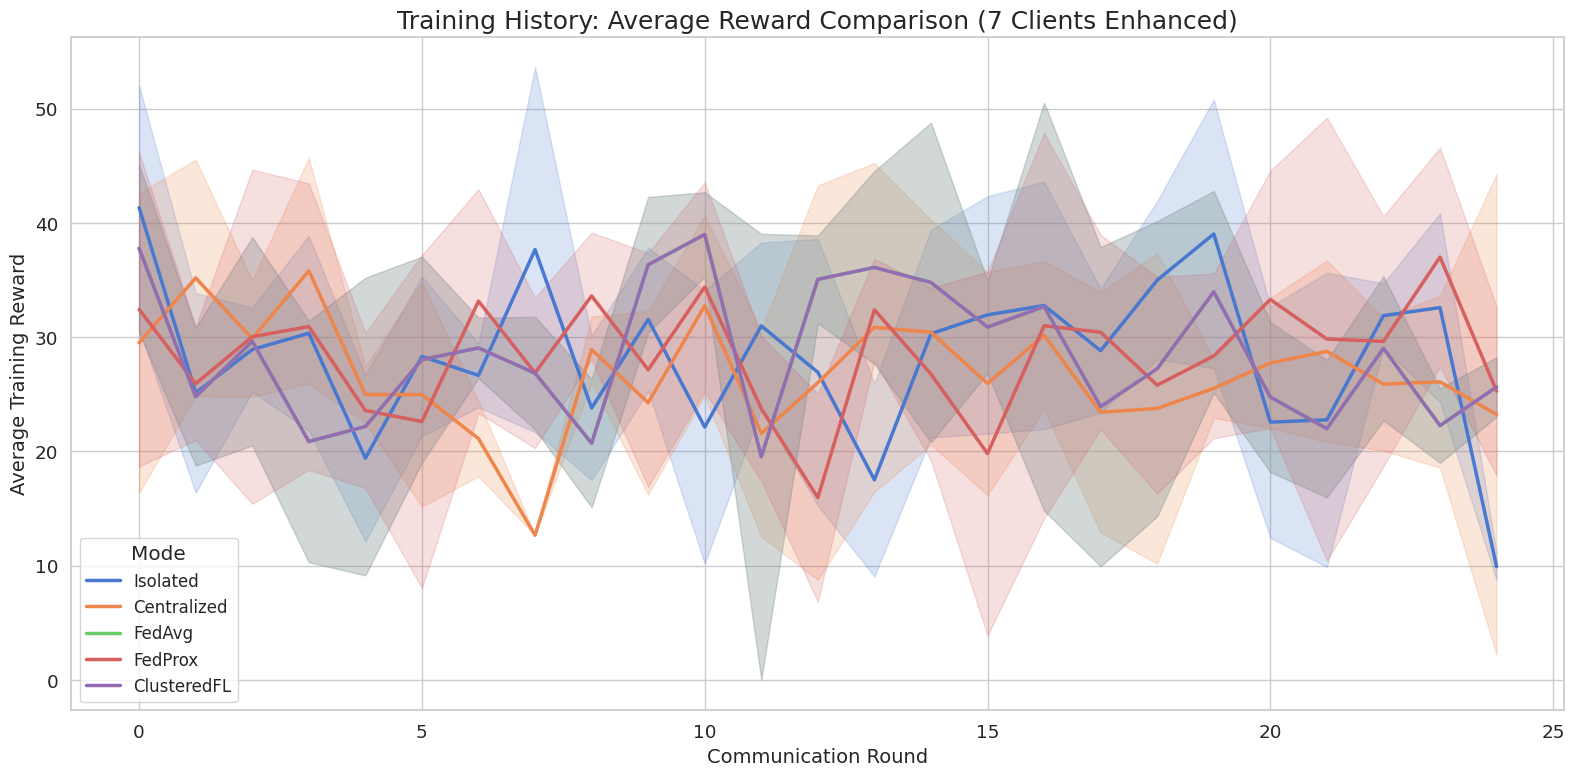

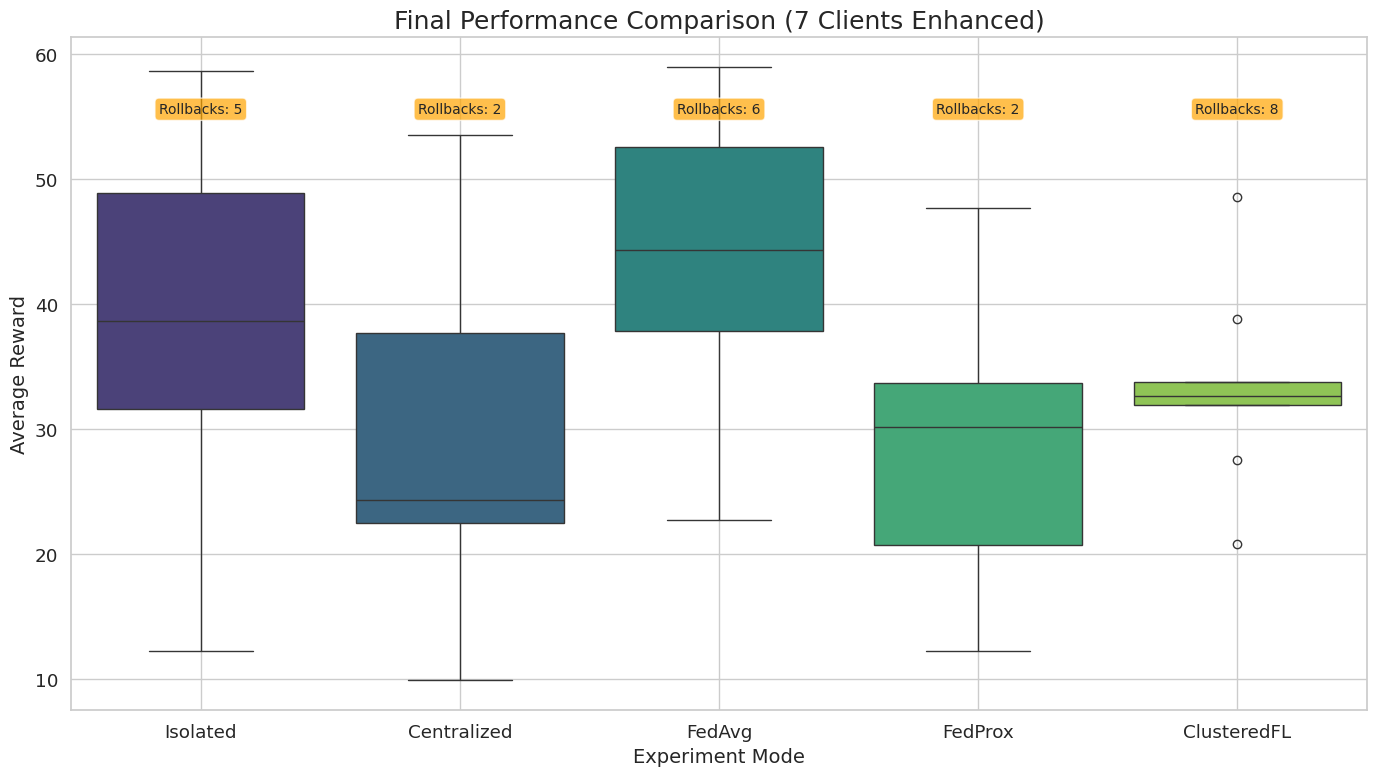

✅ Cell 9: 結果視覺化 (多模式隱私曲線修正版) 完成。


In [10]:
# @title Cell 9: 📊 結果視覺化 (多模式隱私曲線修正版)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os, glob, json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"❌ 找不到結果目錄: {base_output_dir}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try: seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError): continue

        for mode_folder in sorted(os.listdir(os.path.join(base_output_dir, seed_folder))):
            exp_path = os.path.join(base_output_dir, seed_folder, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))
            config_files = glob.glob(os.path.join(exp_path, '*_config.json'))

            if config_files and config_data is None:
                try:
                    with open(config_files[0], 'r') as f: config_data = json.load(f)
                except Exception as e: print(f"警告: 讀取設定檔失敗: {e}")

            def read_and_append(file_list, data_list, mode_name):
                if not file_list: return
                try:
                    if os.path.exists(file_list[0]) and os.path.getsize(file_list[0]) > 0:
                        df = pd.read_csv(file_list[0])
                        df['mode'] = mode_name; df['seed'] = seed
                        data_list.append(df)
                except pd.errors.EmptyDataError: print(f"警告: 空檔案: {file_list[0]}")

            read_and_append(eval_files, all_evals, mode_folder)
            read_and_append(history_files, all_histories, mode_folder)
            read_and_append(privacy_files, all_privacies, mode_folder)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), config_data

# 主要視覺化邏輯
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
BASE_OUTPUT_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_enhanced"
FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("❌ 找不到任何結果檔案")
else:
    SEEDS = [42, 2024, 888]
    mode_order = ["Isolated", "Centralized", "FedAvg", "FedProx", "ClusteredFL"]
    print(f"✅ 成功載入結果")

    # 圖 1: 訓練歷史
    if not history_df.empty:
        plt.figure(figsize=(16, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5)
        plt.title('Training History: Average Reward Comparison (7 Clients Enhanced)', fontsize=18)
        plt.xlabel('Communication Round', fontsize=14)
        plt.ylabel('Average Training Reward', fontsize=14)
        plt.legend(title='Mode', fontsize=12); plt.grid(True); plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_7clients.png'), dpi=300)
        plt.show()

    # 圖 2: 最終性能對比
    if not eval_df.empty:
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'PFL Fine-tuned Reward'})
        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='PFL Fine-tuned Reward', order=mode_order, palette="viridis")

        # 添加PFL回退統計
        if 'pfl_rollback' in eval_to_plot.columns:
            rollback_counts = eval_to_plot.groupby('mode')['pfl_rollback'].sum()
            for i, mode in enumerate(mode_order):
                if mode in rollback_counts:
                    plt.text(i, plt.gca().get_ylim()[1] * 0.9, f'Rollbacks: {rollback_counts[mode]}',
                            ha='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7))

        plt.title('Final Performance Comparison (7 Clients Enhanced)', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14); plt.ylabel('Average Reward', fontsize=14)
        plt.grid(True); plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_7clients.png'), dpi=300)
        plt.show()

    # 修正4: 隱私曲線多模式視覺化
    if not privacy_df.empty and loaded_config:
        plot_modes = ["Isolated", "Centralized", "FedAvg", "FedProx", "ClusteredFL"]
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(plot_modes)].dropna()

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))

            # 修正4: 多模式對比，用不同線型標記early-stop
            for mode in plot_modes:
                mode_data = privacy_to_plot[privacy_to_plot['mode'] == mode]
                if mode_data.empty: continue

                # 檢查是否有early stop
                has_abort = 'aborted_round' in mode_data.columns and mode_data['aborted_round'].notna().any()
                linestyle = '--' if has_abort else '-'

                sns.lineplot(data=mode_data, x='round', y='epsilon',
                            label=f"{mode}{'(Aborted)' if has_abort else ''}",
                            linestyle=linestyle, linewidth=2.5)

            # 添加early-stop閾值線
            if loaded_config and 'dp_max_epsilon' in loaded_config:
                plt.axhline(y=loaded_config['dp_max_epsilon'], color='red',
                           linestyle=':', alpha=0.7, label=f"Early Stop Threshold (ε={loaded_config['dp_max_epsilon']})")

            target_eps = loaded_config.get('dp_target_epsilon', 'N/A')
            target_delta = loaded_config.get('dp_target_delta', 'N/A')

            plt.title(f'Privacy Cost (ε) Comparison Across All Modes (Target ε={target_eps})', fontsize=16)
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel(f'Privacy Loss, Epsilon (ε) at δ={target_delta}', fontsize=14)
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_multimode.png'), dpi=300)
            plt.show()

print("✅ Cell 9: 結果視覺化 (多模式隱私曲線修正版) 完成。")
